In [32]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [33]:
set.seed(1234)
options(digits=2)
stats <- c()

In [34]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "NO"
}

In [35]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [36]:
integrated_h5_path  <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [38]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE6-2b 36 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_1 
Running Lib_2 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_2 
Running Lib_3 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 0 guides found
Skipping DE2-1b 0 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_3 


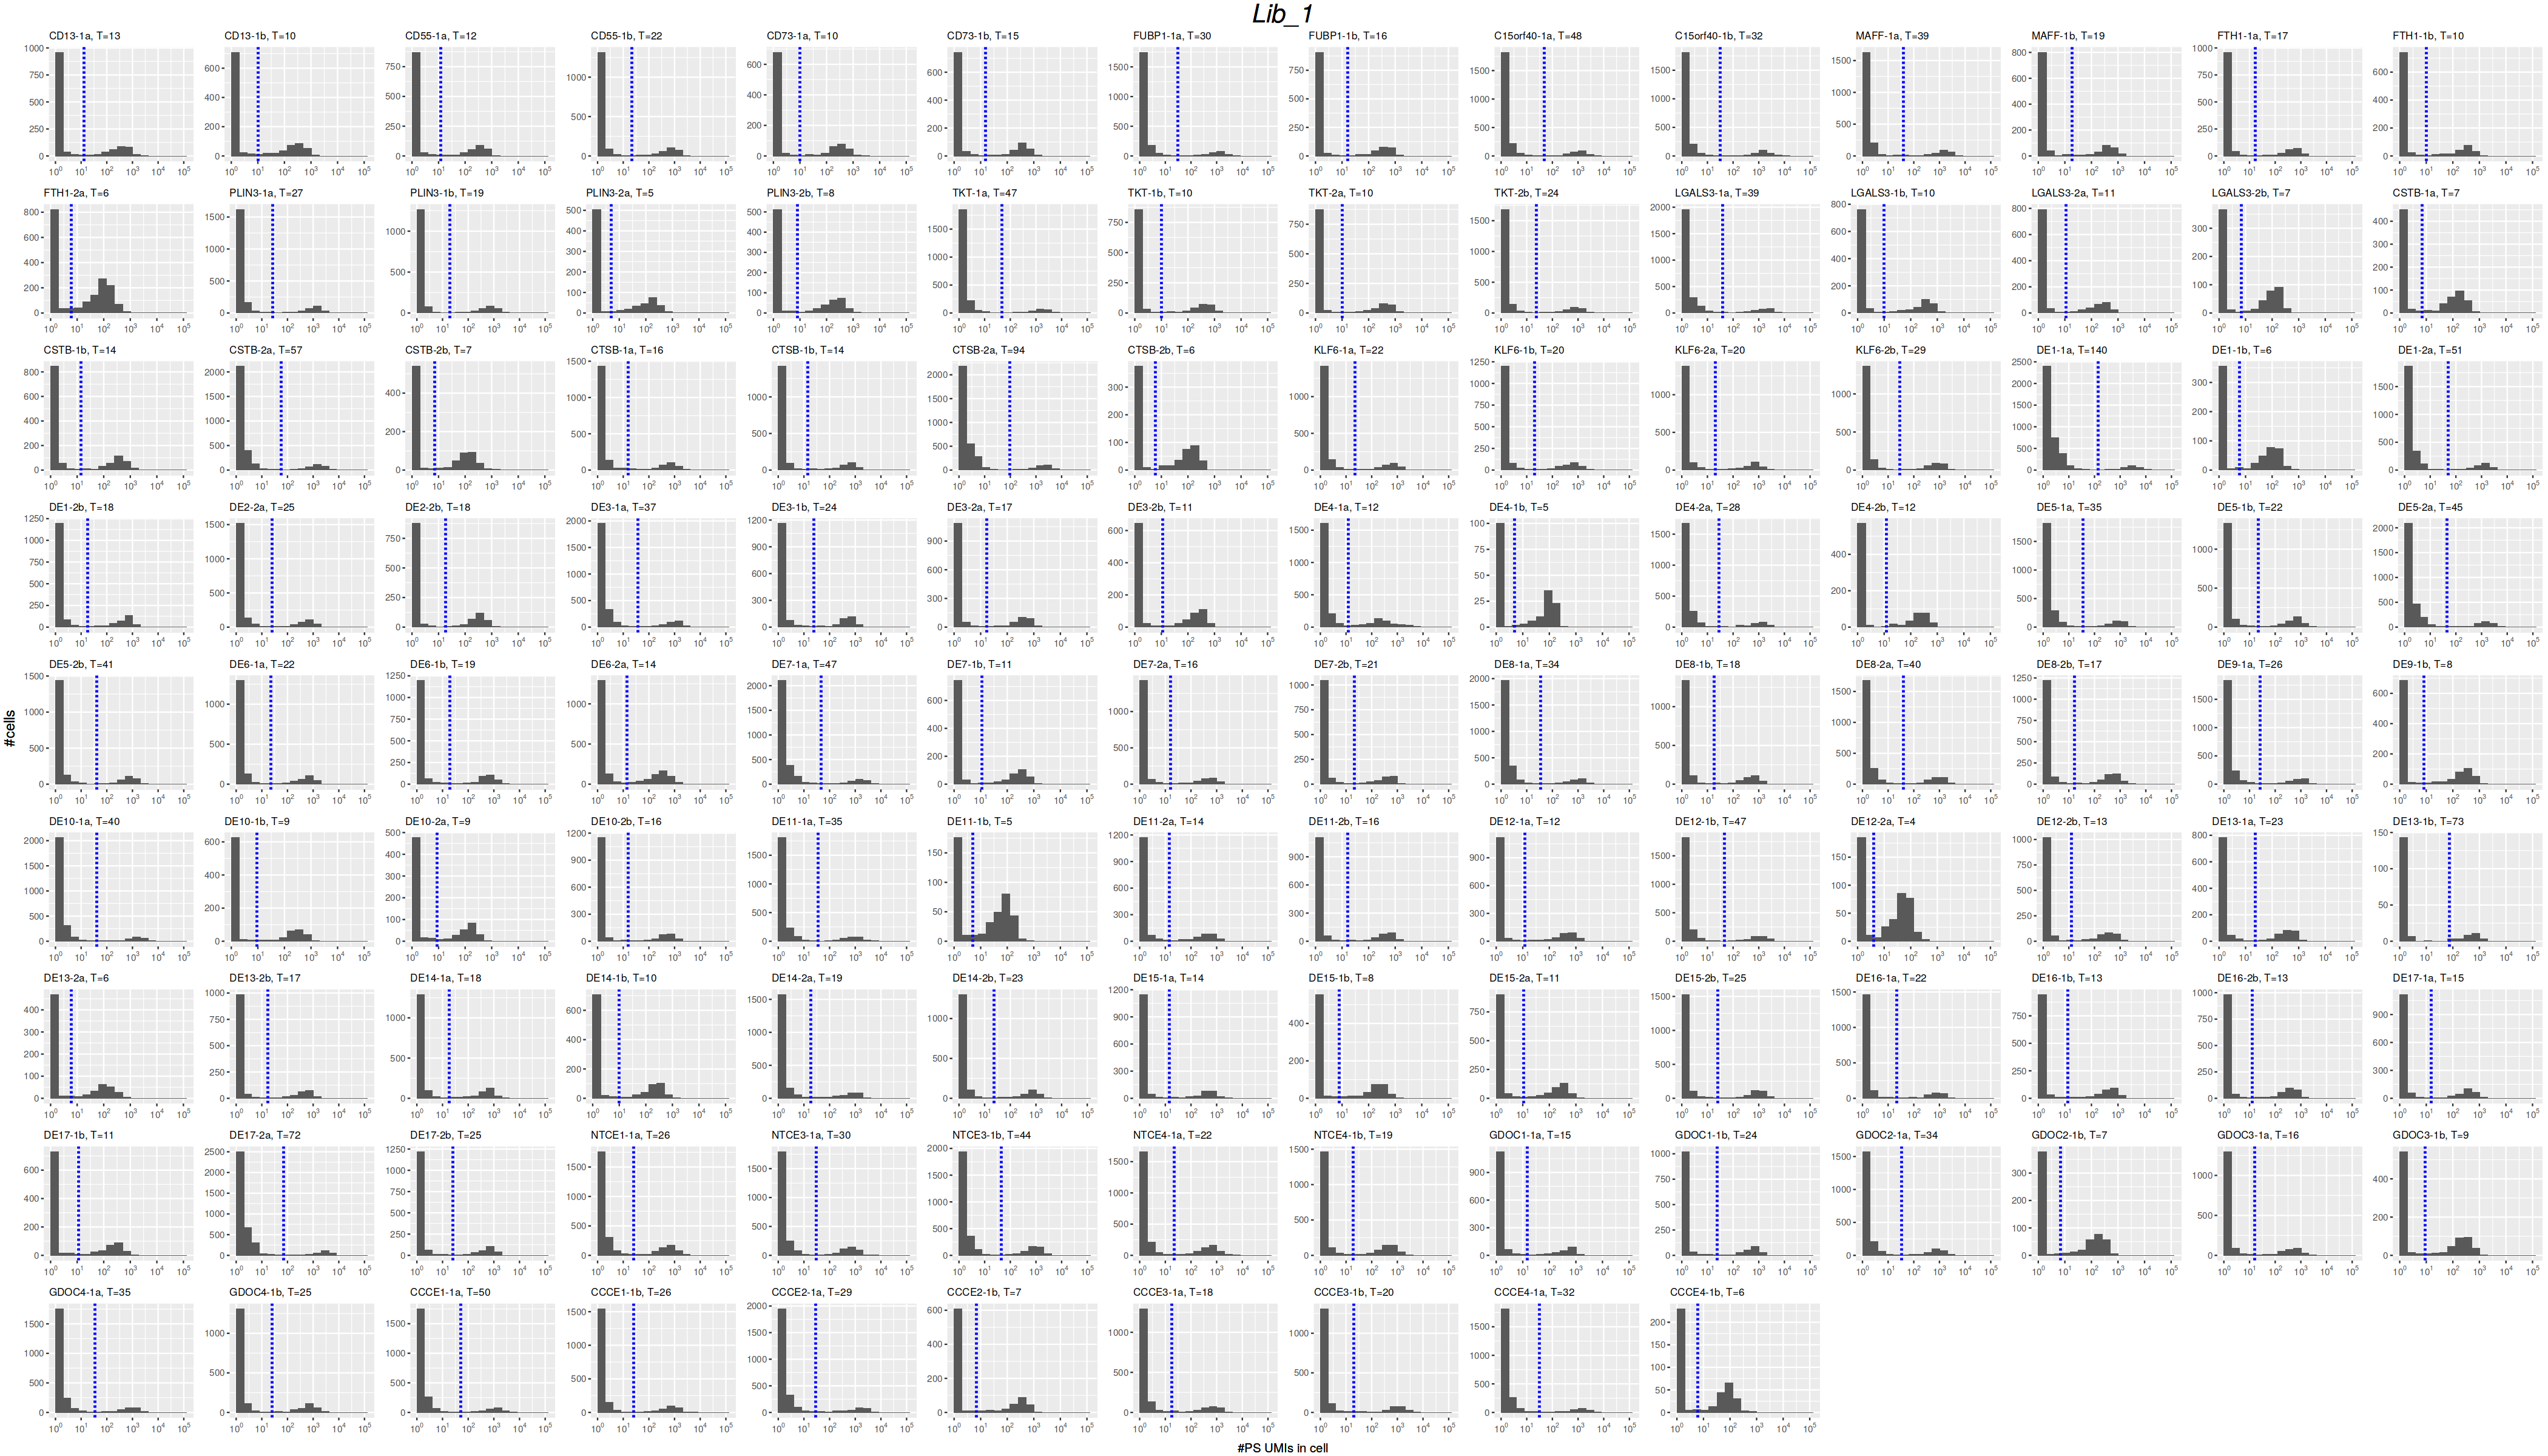

Running Lib_4 
Skipping FTH1-2b 0 guides found
Skipping DE2-1a 2 guides found
Skipping DE2-1b 1 guides found
Skipping DE9-2a 0 guides found
Skipping DE9-2b 0 guides found
Skipping DE16-2a 0 guides found
Skipping NTCE1-1b 0 guides found
Skipping NTCE2-1a 0 guides found
Skipping NTCE2-1b 0 guides found
Completed Lib_4 


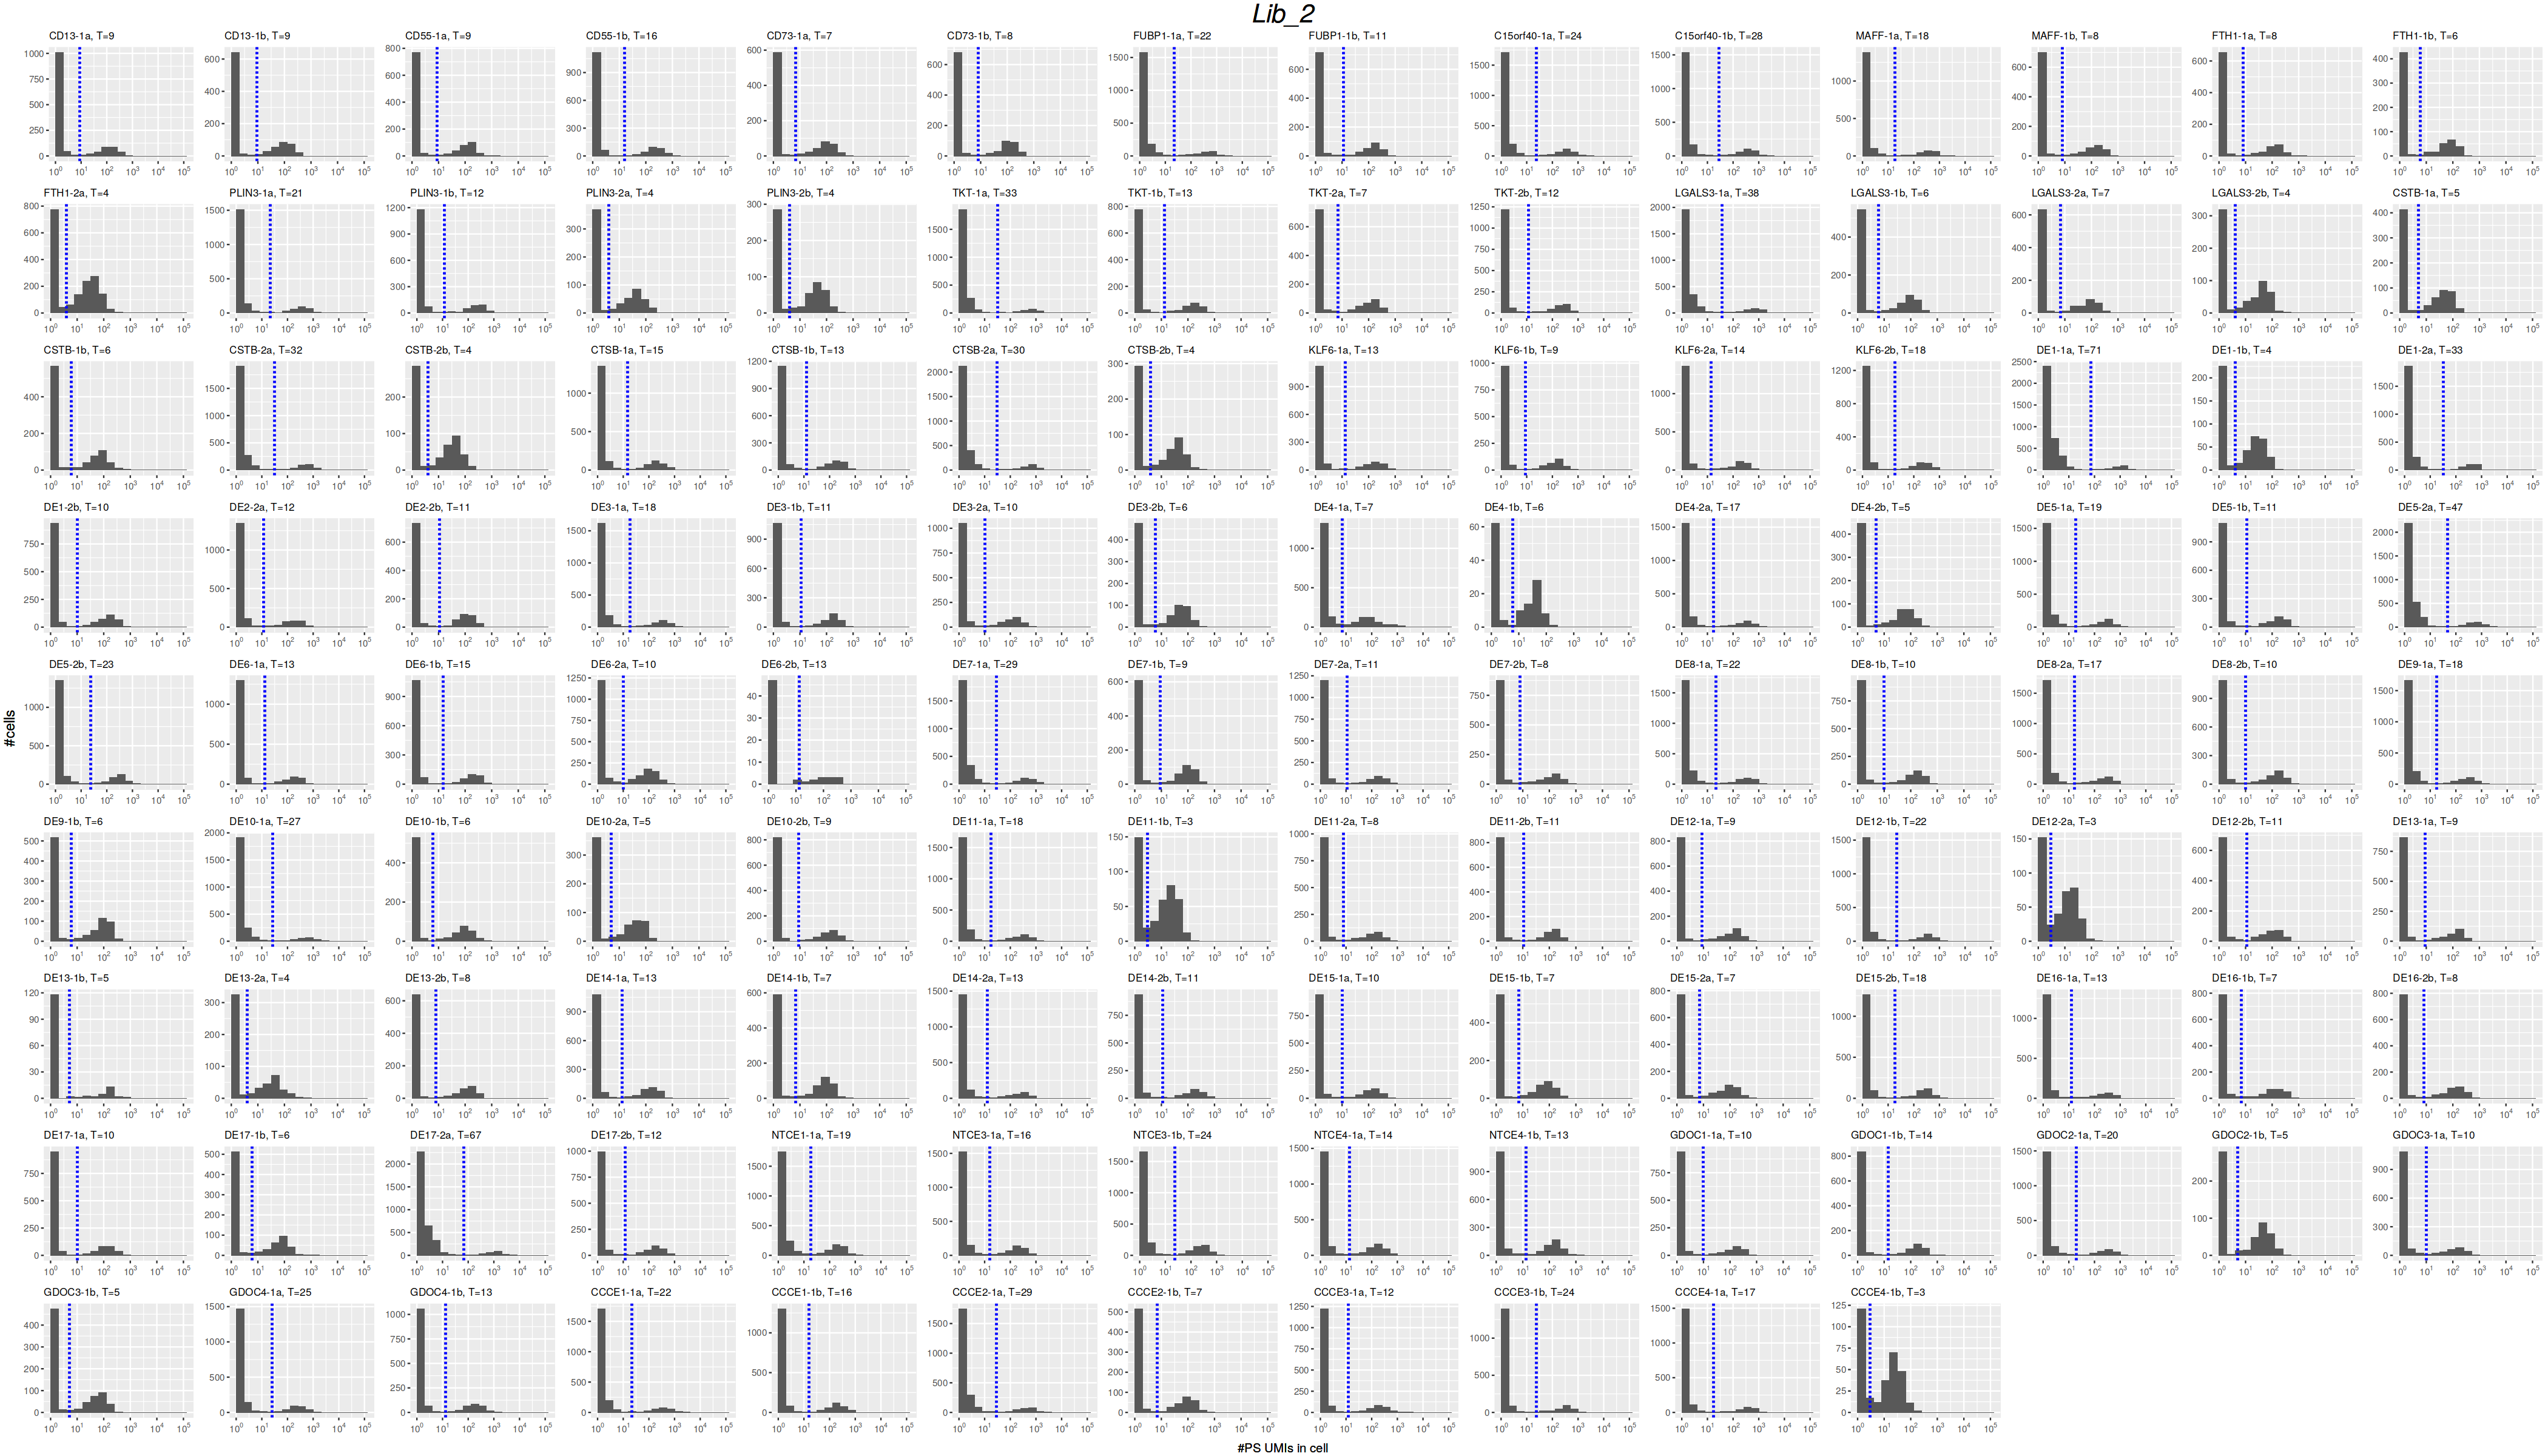

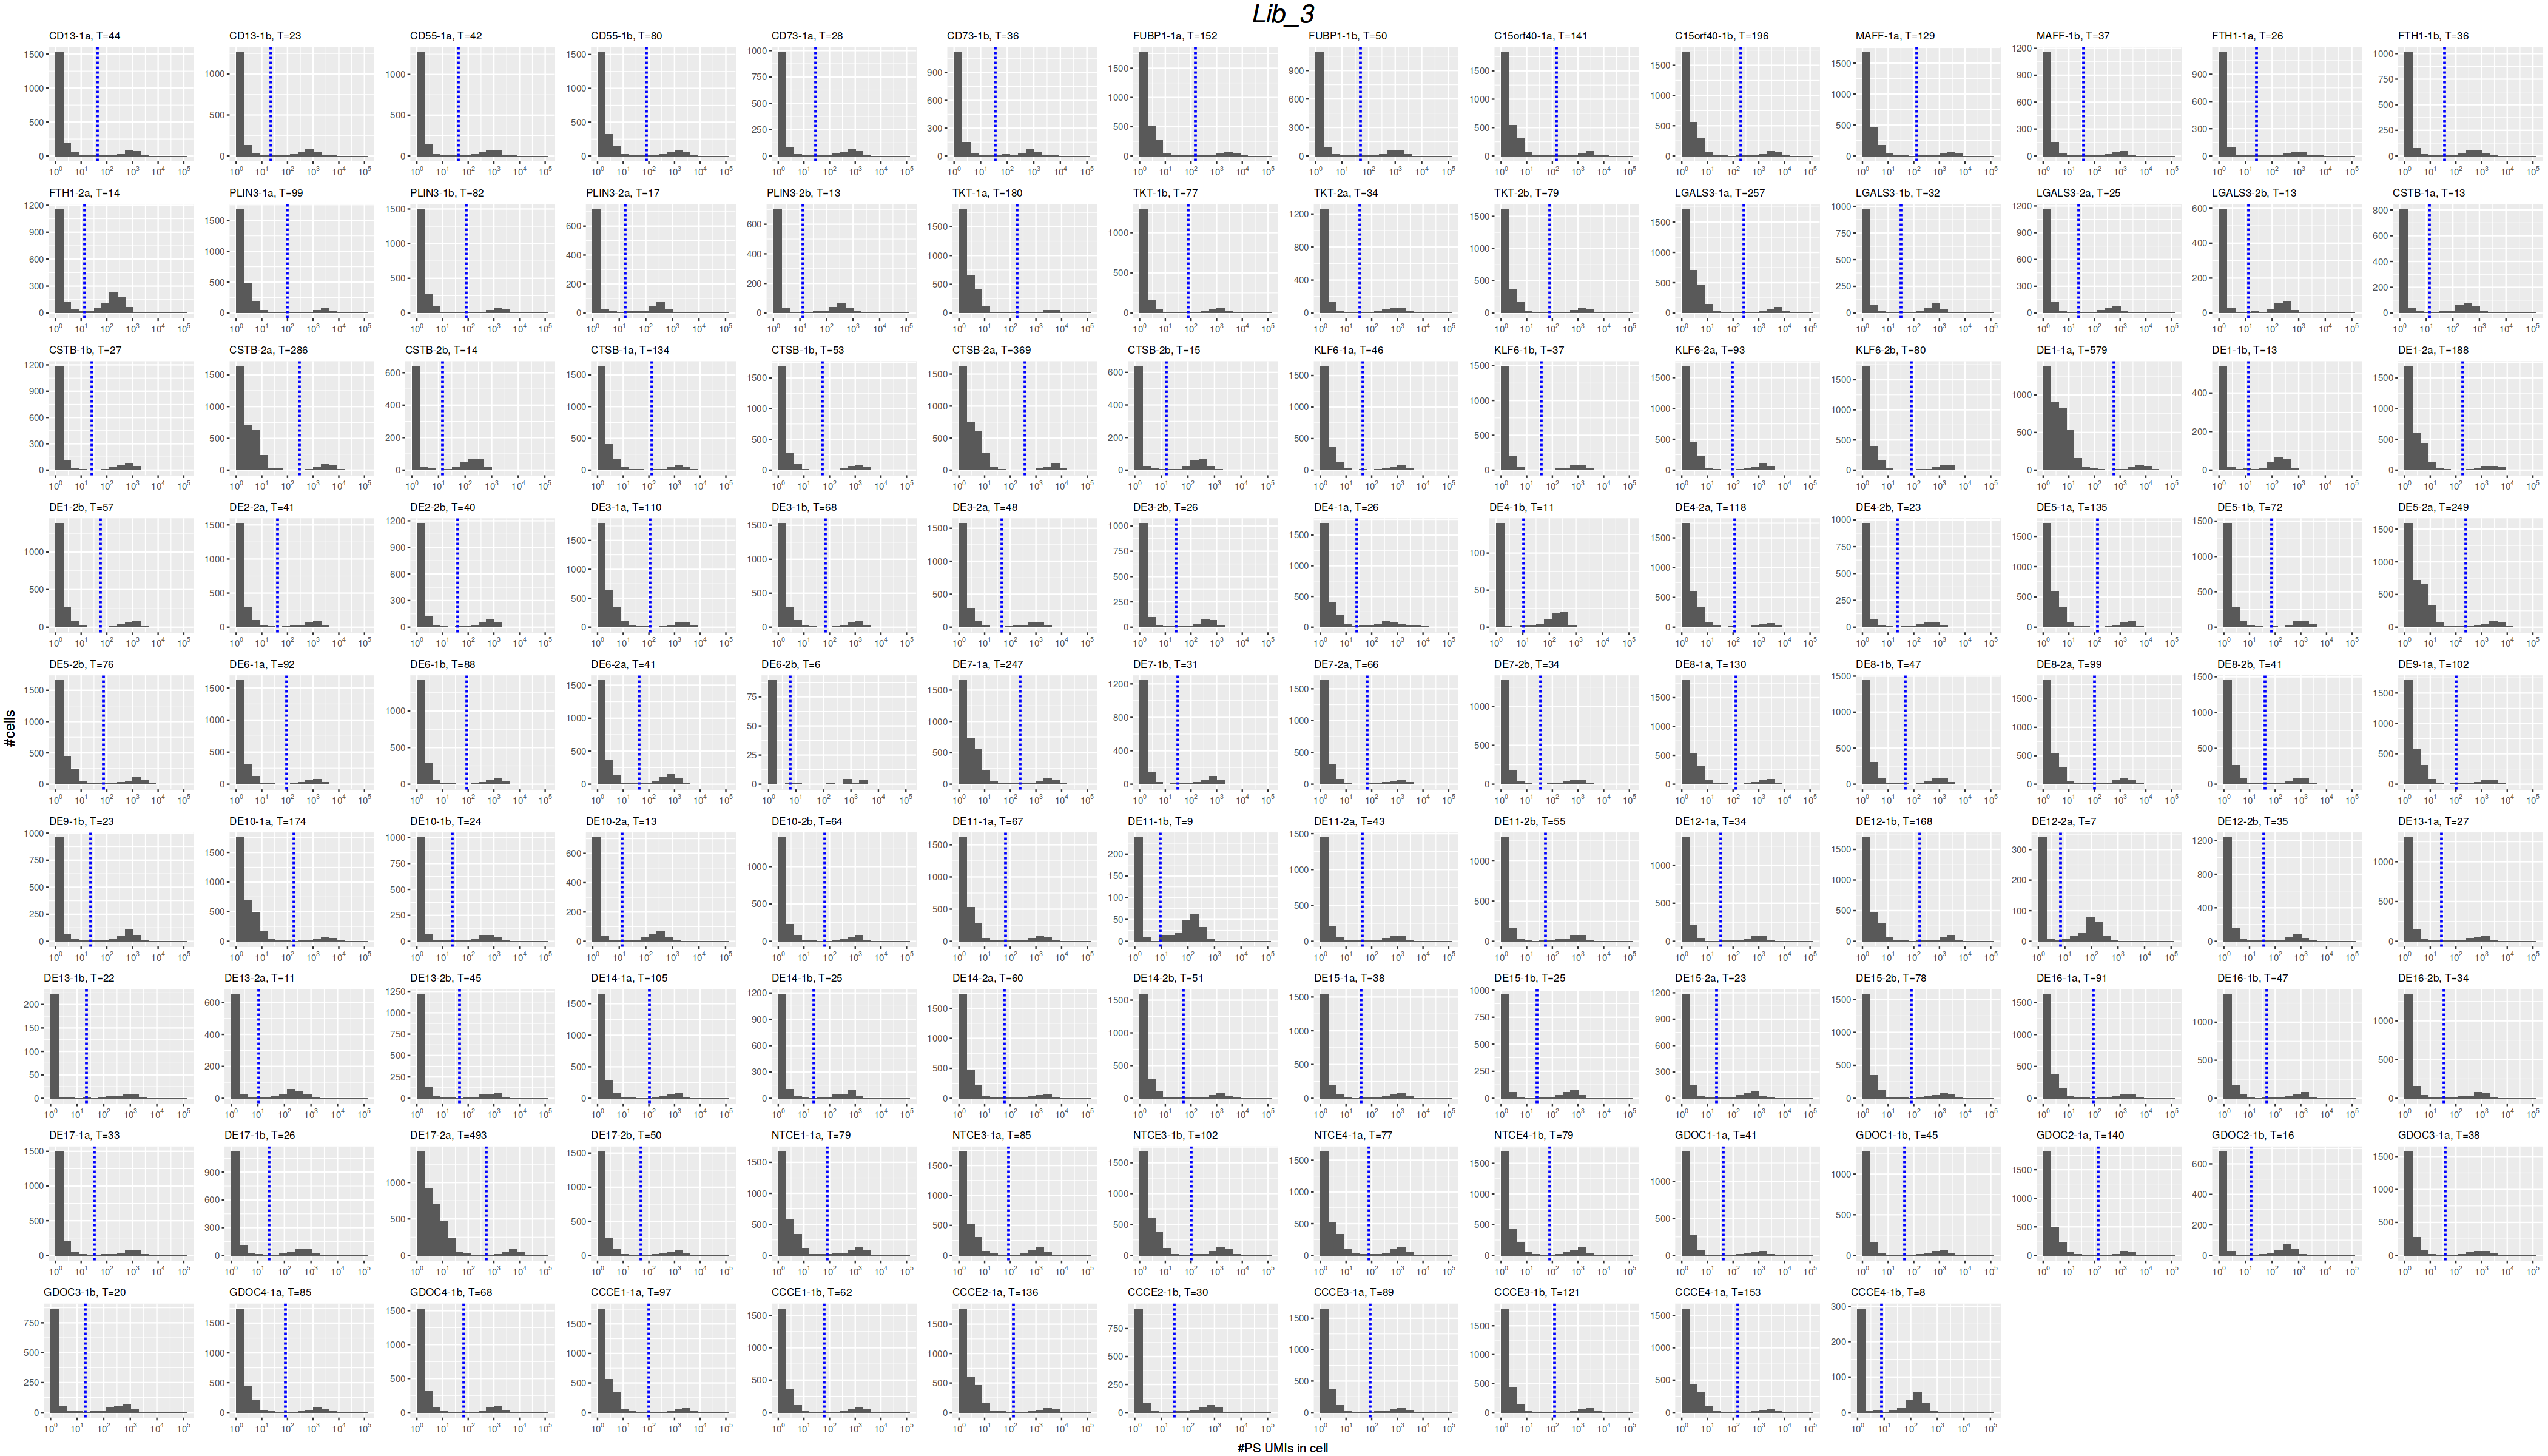

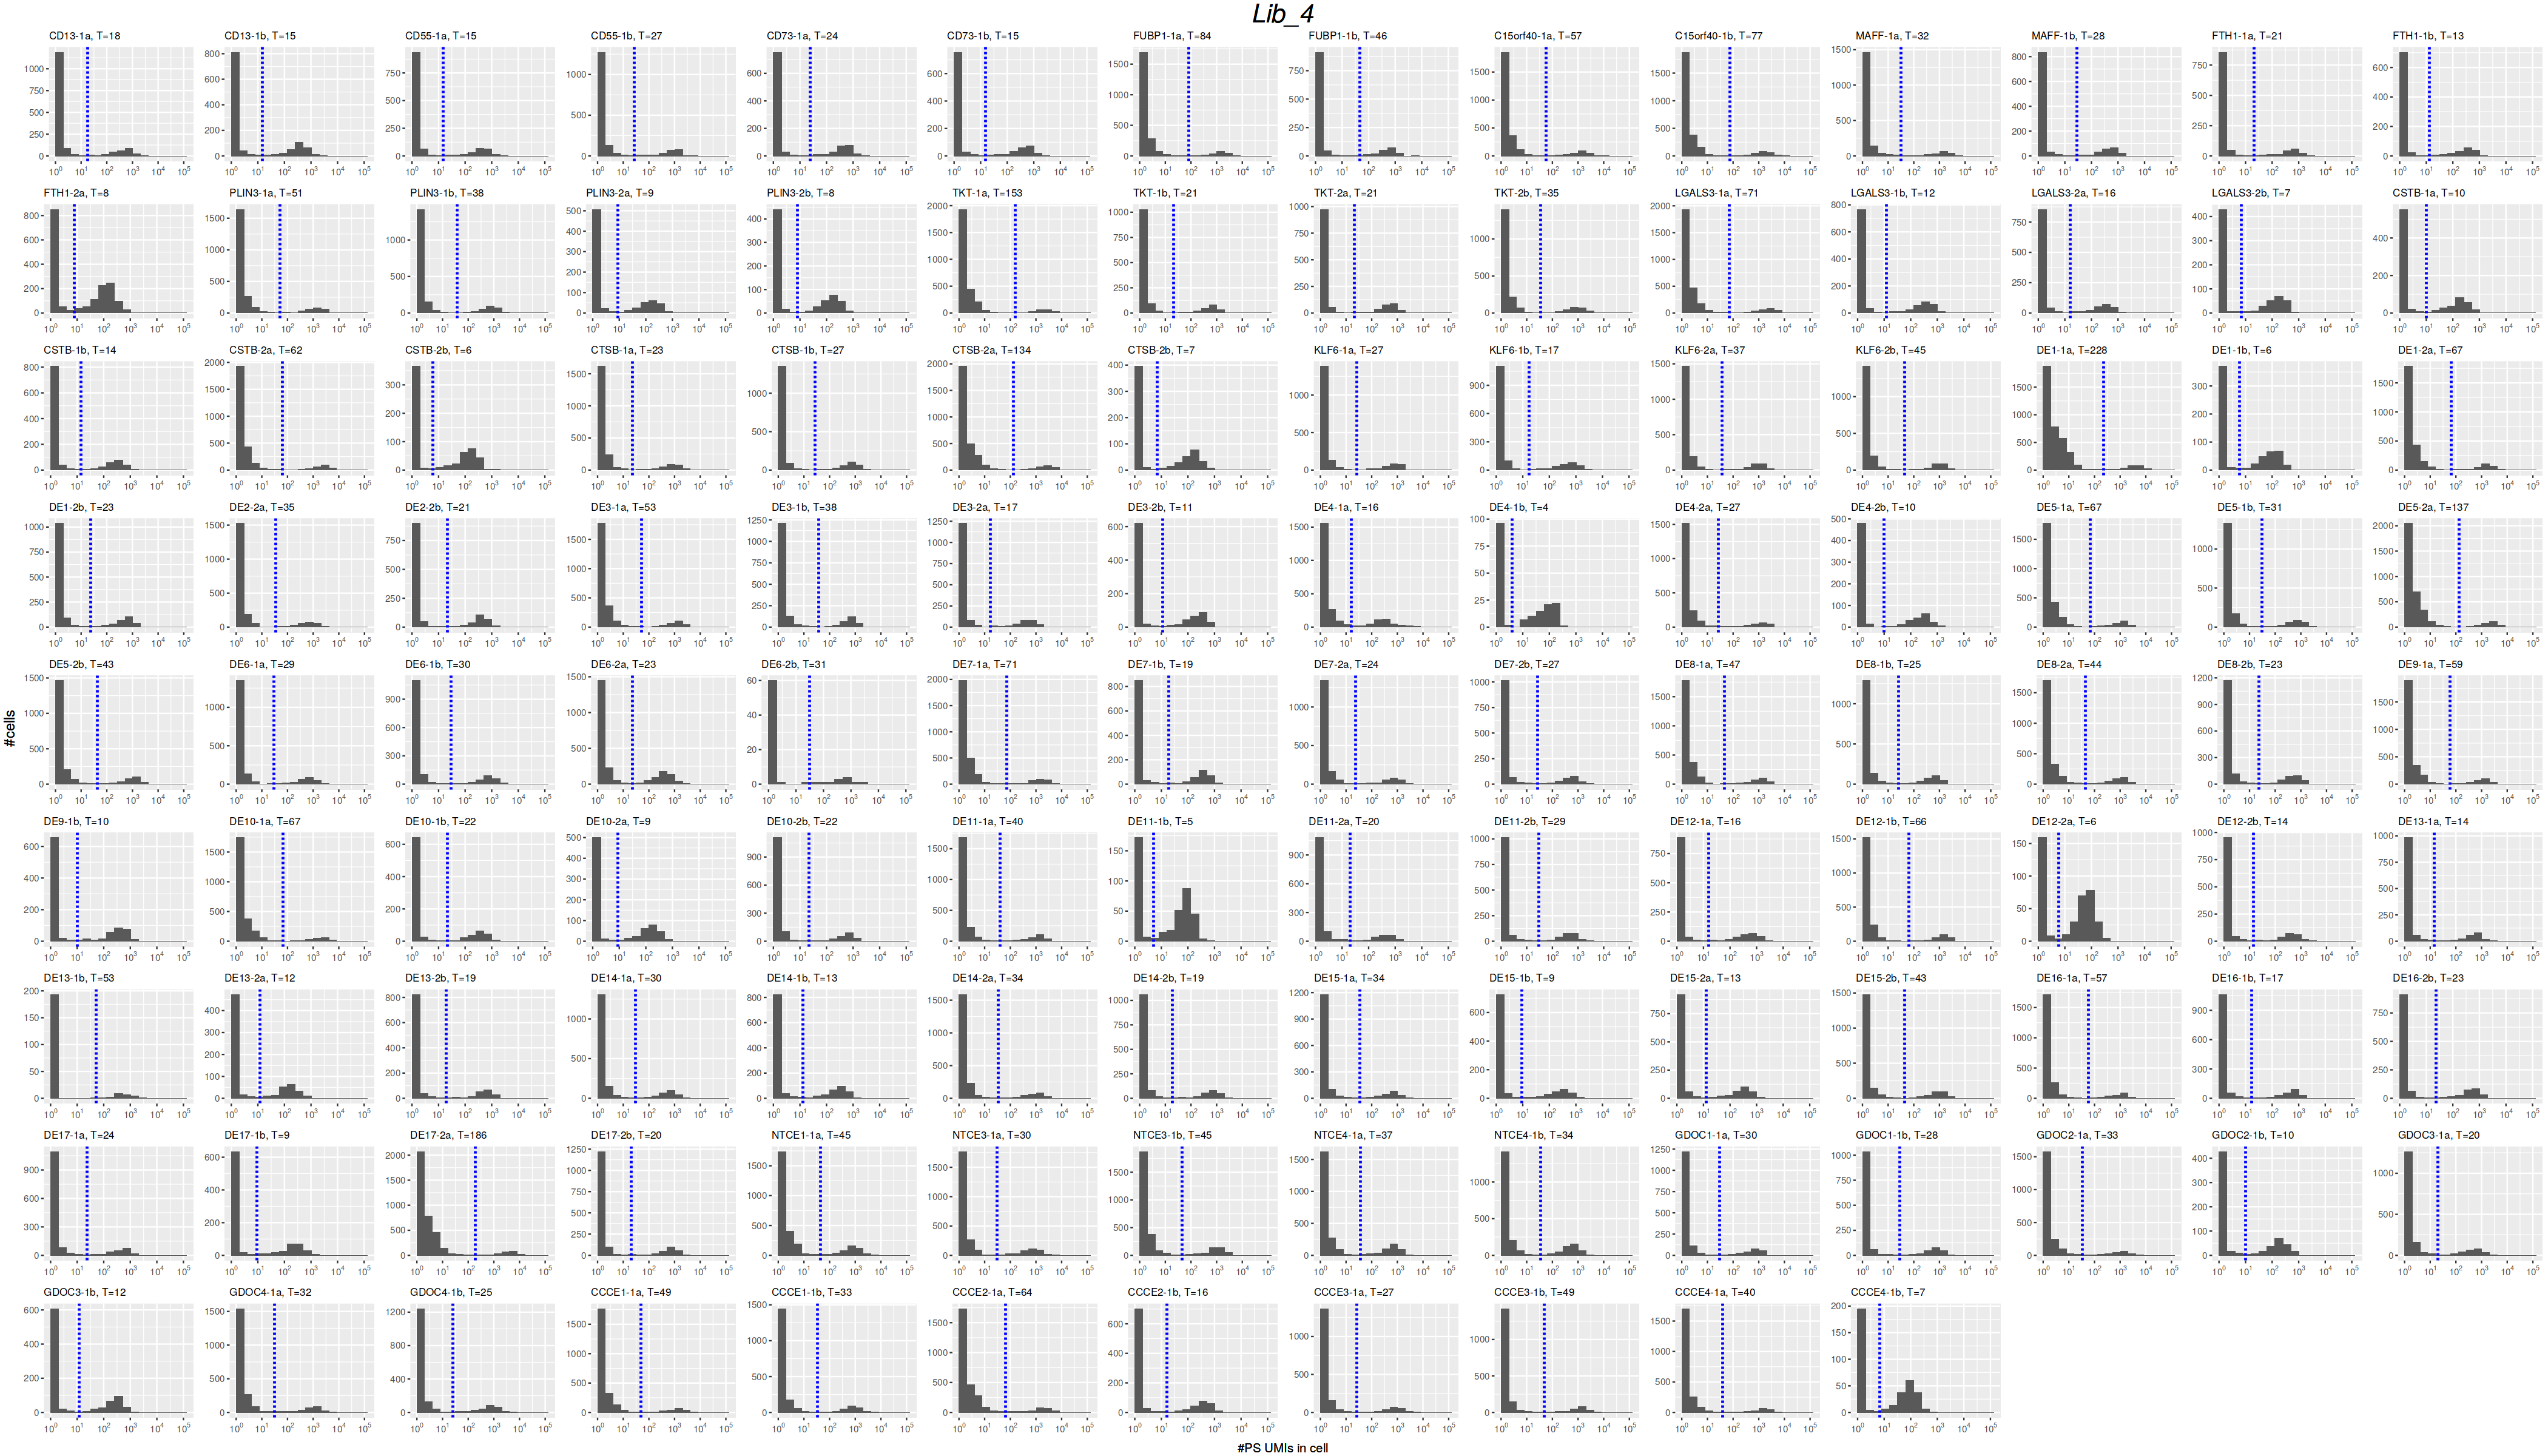

In [7]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=35, repr.plot.height=20)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 14, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    ggsave(
        file = paste0(pdf_path, library_name, "_guide_distributions.pdf"), 
        plt,
        width = 22, 
        height = 17, 
        dpi = 300
    )
}

# Write thresholds to file

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
head(df_thresholds)
write.table(df_thresholds, thr_f_name, sep="\t", quote = F, row.names = F)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15


In [9]:
head(df_thresholds)

,batch,guide,threshold
,<chr>,<chr>,<chr>
1,Lib_1,CD13-1a,13
2,Lib_1,CD13-1b,10
3,Lib_1,CD55-1a,12
4,Lib_1,CD55-1b,22
5,Lib_1,CD73-1a,10
6,Lib_1,CD73-1b,15


# Update the Seurat object with Poission-Gaussian calls 

### Load thresholds

In [39]:
### Load THRESHOLDS.tsv
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)
### Load guide df
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting


### Get the list of pertubed cells for each guide

In [40]:
perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds)

In [41]:
df_calls = enframe(perturbed_cells_by_guide) %>% unnest(2)
df_calls = as.data.frame(df_calls)
df_calls$guide <- as.character(df_calls$name)
df_calls$cell  <- as.character(df_calls$value)
df_calls$name <- NULL
df_calls$value <- NULL
df_calls$plasmid <- sub(".$", "", df_calls$guide)

In [42]:
df_calls_wide <- df_calls %>% 
    group_by(cell) %>% 
    summarise(guide_calls = paste(unique(guide), collapse = '|'), plasmid_calls = paste(unique(plasmid), collapse = '|'))

In [43]:
df_calls_wide$n_guides   <- str_count(df_calls_wide$guide_calls, "\\|") + 1
df_calls_wide$n_plasmids <- str_count(df_calls_wide$plasmid_calls, "\\|") + 1
df_calls_wide = as.data.frame(df_calls_wide)
rownames(df_calls_wide) <- df_calls_wide$cell
df_calls_wide$cell <- NULL

In [44]:
head(df_calls_wide)

,guide_calls,plasmid_calls,n_guides,n_plasmids
,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3
AAACCCAAGCCATTTG-1_4,CD55-1b|DE2-2a,CD55-1|DE2-2,2,2
AAACCCAAGCCGATAG-1_4,NTCE1-1a,NTCE1-1,1,1
AAACCCAAGCTTAAGA-1_1,CD13-1a|CD13-1b|DE3-2a|DE3-2b|CCCE3-1b,CD13-1|DE3-2|CCCE3-1,5,3
AAACCCAAGGAACTAT-1_3,FTH1-2a|DE7-1a|DE7-1b|DE8-2a|DE8-2b|DE14-1a|DE14-1b|DE14-2a|DE14-2b,FTH1-2|DE7-1|DE8-2|DE14-1|DE14-2,9,5


### Update the Seurat object with Poisson-Gaussian guide calls

Update the Seurat object

In [47]:
cols2rename = c('PS_call', 'construct_call', 'target_call', 'nCalled_Constructs', 'nPS_calls', 'nCalled_sgRNA_UMIs')
df_dummy = seurat_combined@meta.data
for(i in 1:length(cols2rename)) {
    colname = cols2rename[i]
    names(df_dummy)[names(df_dummy) == colname] <- paste0('cellranger_', colname) 
}
df_dummy = merge(df_dummy, df_calls_wide, by = 0, all.x = T)
rownames(df_dummy) <- df_dummy$Row.names
df_dummy$Row.names <- NULL
seurat_combined@meta.data = df_dummy

In [48]:
nrow(seurat_combined@meta.data)
nrow(df_dummy)

[1] 21363

[1] 21363

In [49]:
head(seurat_combined,2)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,cellranger_PS_call,⋯,cellranger_nPS_calls,cellranger_nCalled_sgRNA_UMIs,status,donor,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25177,5887,3237,19,26187,5837,Screen1_66guides,Lib_1,6.7,FUBP1_1a|DE6_2a|DE8_1a|DE8_1b|DE15_2b,⋯,5,941|248|953|446|628,singlet,3,0,0,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGAGGTCAC-1_3,10230,3697,8236,49,24575,4484,Screen1_66guides,Lib_3,5.7,DE14_2b|NTCE1_1a|GDOC4_1a,⋯,3,2994|1067|4097,singlet,3,1,1,DE14-2b|NTCE1-1a|GDOC4-1a,DE14-2|NTCE1-1|GDOC4-1,3,3


### Save the updated Seurat object

In [50]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat_combined, integrated_h5_path, overwrite = T, verbose = F)
}

Warning message:
"Overwriting previous file /home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding counts for sgRNA

Adding data for sgRNA

No variable features found for sgRNA

No feature-level metadata found for sgRNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap.rna

No loadings for umap.rna

No projected loadings for umap.rna

No standard devi

# Visualizations using the PG guide-called data

### Constructs per cell distribution

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


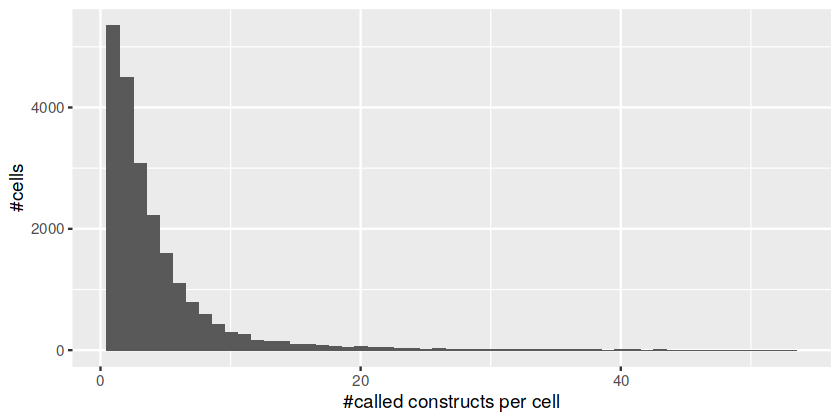

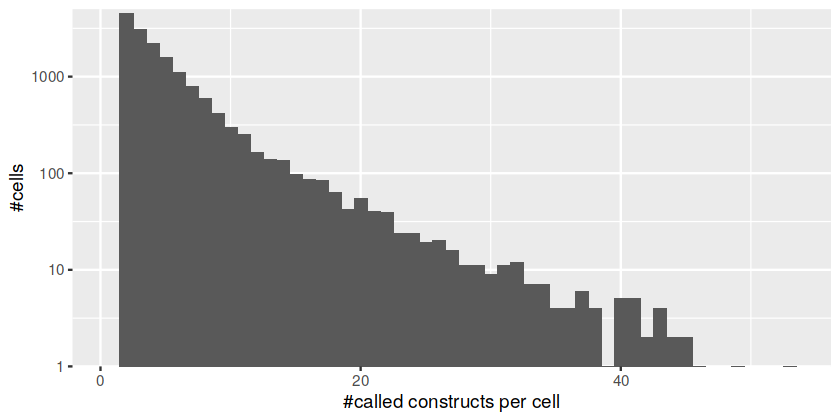

In [52]:
p5 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    labs(x = "#called constructs per cell") +
    labs(y = "#cells") 

p6 <- ggplot(df_calls_wide, aes(x = n_plasmids)) +
    geom_histogram(binwidth=1) +
    scale_y_log10(limits = c(1, 5000), expand = c(0, 0)) +
    labs(x = "#called constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=7, repr.plot.height=3.5)
p5
p6

### Plot cells per plasmid distribution

In [53]:
plasmid_calls = seurat_combined@meta.data$plasmid_calls
plasmid_calls = str_split(paste0(plasmid_calls, collapse = "|"), "\\|")
df_dummy = as.data.frame(table(plasmid_calls))

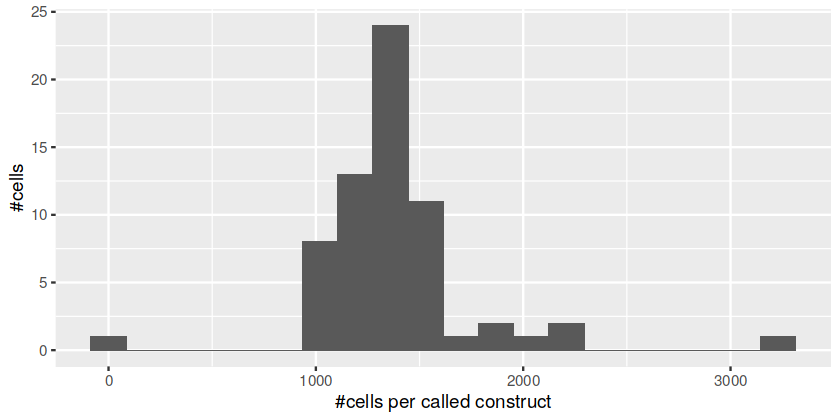

In [54]:
ggplot(df_dummy, aes(Freq)) +
    geom_histogram(bins=20) +
    labs(x = "#cells per called construct") +
    labs(y = "#cells") 
    

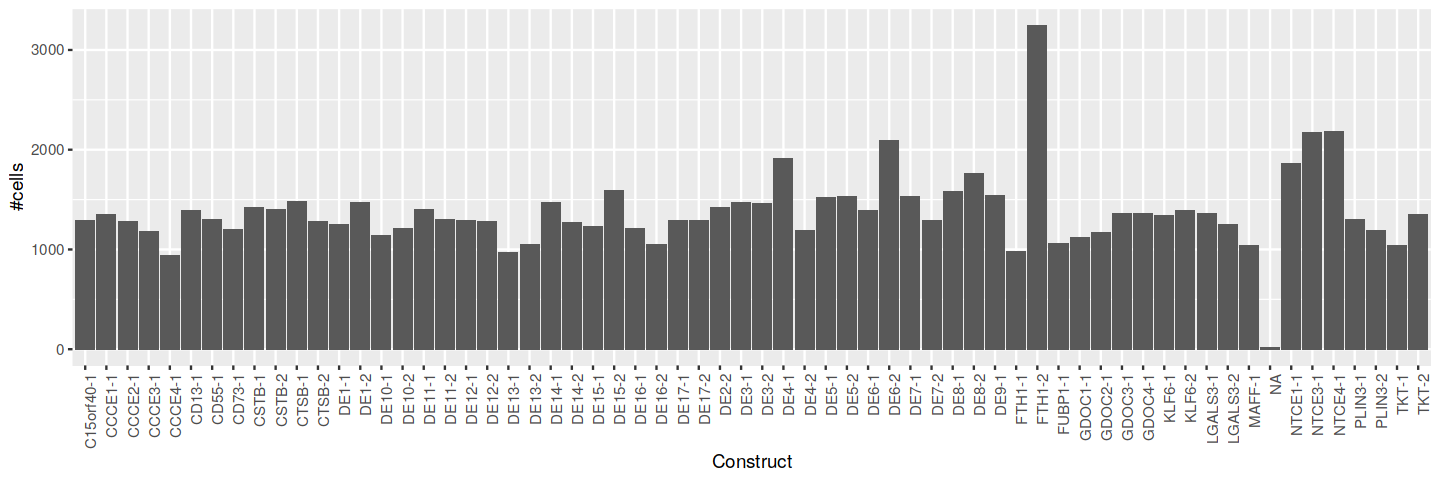

In [55]:
p6 <- ggplot(df_dummy, aes(x=plasmid_calls, y=Freq)) +
    geom_bar(stat='identity') +
    labs(x = "Construct") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p6